In here we tried to perform the model on lsoa level, summerzing all the sentences vectors within one lsoa, use these to predict gentrification.

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/all_stru_data_20_22.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [98]:
print(lsoa_label.columns)

Index(['LSOA 2021', 'borough', 'pop_growth', 'avg_den', 'senior_per',
       'minority_p', 'geometry'],
      dtype='object')


In [5]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data_22.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon', 'wgs84_polygon',
       'description', 'borough', 'street_name', 'polygon.geometries',
       'polygon.type',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [ ]:
print(text["description"].dropna().head(3))

0    Construction of ground floor and first floor r...
1    Prior Approval for the construction of a singl...
2    Samples of facing materials; details of typica...
Name: description, dtype: object


In [43]:
# 1. 原始含 description 的记录数量
print("Step 1 - 原始记录（text）总数：", len(text))
print("Step 2 - 非空 description 数量：", text['description'].notnull().sum())

# 2. 同时满足：有 polygon 坐标、也有 description 的数量
subset = text[text['wgs84_polygon.coordinates'].notnull() & text['description'].notnull()]
print("Step 3 - 筛选后记录数：", len(subset))
print("Step 4 - 筛选后是否还有 description：", subset['description'].notnull().sum())

# 3. 看看 polygon.coordinates 结构
print("Step 5 - 坐标样例：", subset['wgs84_polygon.coordinates'].iloc[0])
print("Step 6 - 坐标类型：", type(subset['wgs84_polygon.coordinates'].iloc[0]))

Step 1 - 原始记录（text）总数： 534080
Step 2 - 非空 description 数量： 364194
Step 3 - 筛选后记录数： 308122
Step 4 - 筛选后是否还有 description： 308122
Step 5 - 坐标样例： [[[0.0404025, 51.4486397], [0.040415099999999995, 51.4486966], [0.040416099999999996, 51.4487033], [0.0404248, 51.448754], [0.0405711, 51.448742], [0.040531899999999996, 51.4485417], [0.040528999999999996, 51.4485404], [0.040494499999999996, 51.4485239], [0.0403732, 51.4484671], [0.040401599999999996, 51.4486375], [0.0404025, 51.4486397]]]
Step 6 - 坐标类型： <class 'str'>


In [44]:
import json
from shapely.geometry import Polygon

def safe_parse_polygon(coord_str):
    try:
        # 将字符串解析为嵌套列表
        coords = json.loads(coord_str) if isinstance(coord_str, str) else coord_str
        return Polygon(coords[0])
    except Exception as e:
        return None

# 筛选有坐标和描述的数据
text_valid = text[
    text['wgs84_polygon.coordinates'].notnull() &
    text['description'].notnull()
].copy()

# 构建 geometry 列
text_valid['geometry'] = text_valid['wgs84_polygon.coordinates'].apply(safe_parse_polygon)

# 删除构建失败的
text_valid = text_valid[text_valid['geometry'].notnull()]

# 构建 GeoDataFrame
import geopandas as gpd
gdf_text = gpd.GeoDataFrame(text_valid, geometry='geometry', crs='EPSG:4326')

# ✅ 验证 description 保留
print(gdf_text['description'].dropna().head(3))


1    Prior Approval for the construction of a singl...
2    Samples of facing materials; details of typica...
3    Construction of a single storey detached outbu...
Name: description, dtype: object


In [45]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [46]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [47]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label, how="left",predicate="within")

In [48]:
joined_centroid.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon', 'wgs84_polygon',
       'description', 'borough_left', 'street_name', 'polygon.geometries',
       'polygon.type',
       ...
       'sbert_383', 'geometry', 'centroid', 'index_right', 'LSOA 2021',
       'borough_right', 'pop_growth', 'avg_den', 'senior_per', 'minority_p'],
      dtype='object', length=410)

In [49]:
print(joined_centroid["description"].dropna().head(3))

1    Prior Approval for the construction of a singl...
2    Samples of facing materials; details of typica...
3    Construction of a single storey detached outbu...
Name: description, dtype: object


In [ ]:
# # 按 LSOA 编码分组，取均值（你也可以试试 sum、max 等方式）
# sbert_cols = [f"sbert_{i}" for i in range(384)]
# lsoa_vecs = joined_centroid.groupby("LSOA 2021")[sbert_cols].mean()

# struct_cols = ['pop_growth', 'avg_den', 'senior_per', 'minority_p']
# lsoa_struct = joined_centroid.groupby("LSOA 2021")[struct_cols].mean()

# lsoa_combined = lsoa_vecs.join(lsoa_struct, how='left')

# lsoa_label = joined_centroid[['LSOA 2021']].drop_duplicates()
# lsoa_combined = lsoa_combined.reset_index().merge(lsoa_label, on="LSOA 2021", how="left")

In [18]:
anchor_dict = {
    "residential": ["flat conversion", "refurbishment", "rear extension", "self contained", "flats", "single storey", "storey rear extension"],
    "commercial": ["coffee shop", "illuminated sign", "retail unit upgrade", "use class", "change use"],
    "green": ["park improvement", "landscaping", "tree planting"],
    "cultural": ["artist studios", "cultural space", "gallery conversion"],
    "infrustructure": ["station upgrade", "utilities improvement", "internally illuminated", "ground floor level", "floor level"]
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# 正确计算平均向量：
anchor_vecs = {
    k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict.items()
}

In [51]:
def extract_diverse_anchor_sentences(
    anchor_vecs,           # 你的人工定义 anchor 向量: {anchor_name: vector}
    all_sentences,         # 句子列表: List[str]
    sbert_model,           # SentenceTransformer 模型
    topk,               # 每个 anchor 最多考虑 topk 相似句子作为候选
    anchor_threshold,  # anchor 与句子相似度下限
    sim_threshold     # 被选句子之间最大相似度（越小越多样）
):
    # 编码所有句子为向量
    print("emcoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    anchor_top_sentences = {}

    for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 extract sentences from each category"):
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]

        # 找出相似度高于 anchor_threshold 的 topk 句子
        sorted_idx = np.argsort(sims)[::-1]
        filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

        selected = []
        selected_vecs = []

        for i in filtered_idx:
            sent = all_sentences[i]
            vec = sent_vecs[i]

            # 判断与已选句子的相似度是否都低于 sim_threshold
            if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
                selected.append({"sentence": sent, "score": float(sims[i])})
                selected_vecs.append(vec)

        anchor_top_sentences[cat] = selected
        print(f"✅ {cat}: select {len(selected)} sentences")

    return anchor_top_sentences

In [52]:
# 强制转成字符串 & 去除缺失值
all_sentences = joined_centroid['sentences'].dropna().astype(str).tolist()

In [53]:
print(len(all_sentences))

308122


In [54]:
diverse_results = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,
    all_sentences=all_sentences ,
    sbert_model=sbert_model,
    topk=50,
    anchor_threshold=0.5,
    sim_threshold=0.7
)

emcoding all sentences...


Batches:   0%|          | 0/9629 [00:00<?, ?it/s]

🔍 extract sentences from each category:  20%|██        | 1/5 [00:00<00:02,  1.40it/s]

✅ residential: select 1 sentences


🔍 extract sentences from each category:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

✅ commercial: select 6 sentences


🔍 extract sentences from each category:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

✅ green: select 7 sentences


🔍 extract sentences from each category:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

✅ cultural: select 15 sentences


🔍 extract sentences from each category: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

✅ infrustructure: select 13 sentences


In [55]:
def get_anchor_vecs_from_diverse_results(diverse_results, sbert_model):
    anchor_vecs = {}
    for cat, items in diverse_results.items():
        sentences = [entry["sentence"] for entry in items]
        vecs = sbert_model.encode(sentences, batch_size=32)
        anchor_vecs[cat] = vecs.mean(axis=0)  # 平均向量作为 anchor
    return anchor_vecs

In [56]:
# 获取平均向量组成的 anchor
keyline_vecs = get_anchor_vecs_from_diverse_results(diverse_results, sbert_model)

In [57]:
def score_sentences_against_anchors(anchor_vecs, all_sentences, sbert_model):
    
    print("encoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    scores = {}

    for cat, anchor_vec in anchor_vecs.items():
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]  # shape: (num_sentences,)
        scores[cat] = sims

    # 合成 DataFrame
    import pandas as pd
    score_df = pd.DataFrame(scores)
    score_df['sentence'] = all_sentences

    return score_df

In [58]:
# 调用函数
score_df = score_sentences_against_anchors(
    anchor_vecs=keyline_vecs,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

encoding all sentences...


Batches:   0%|          | 0/9629 [00:00<?, ?it/s]

In [63]:
print(joined_centroid.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon', 'wgs84_polygon',
       'description', 'borough_left', 'street_name', 'polygon.geometries',
       'polygon.type',
       ...
       'sbert_383', 'geometry', 'centroid', 'index_right', 'LSOA 2021',
       'borough_right', 'pop_growth', 'avg_den', 'senior_per', 'minority_p'],
      dtype='object', length=410)


In [84]:
# 加上 LSOA code（确保顺序匹配）
score_df['LSOA 2021'] = joined_centroid['LSOA 2021'].values

# 只保留数值列（通常是 anchor 类别的列）
anchor_score_numeric = score_df.select_dtypes(include='number')

# 添加 LSOA code 回来做分组
anchor_score_numeric['LSOA 2021'] = score_df['LSOA 2021']

# 按 LSOA 聚合 anchor 得分（均值）
anchor_lsoa = anchor_score_numeric.groupby('LSOA 2021').mean().reset_index()


In [ ]:
print(score_df.columns)

Index(['residential', 'commercial', 'green', 'cultural', 'infrustructure',
       'sentence', 'LSOA 2021'],
      dtype='object')


In [87]:
print(anchor_lsoa.shape)

(4812, 6)


In [85]:
import pandas as pd

# 设置你要保留的 anchor 列和 top-N 值
anchor_cols = ['residential', 'commercial', 'green', 'cultural', 'infrustructure']
top_n = 5  # 每个 LSOA 只保留相似度最高的 5 条句子

# 确保 score_df 里有 'LSOA code' 和 anchor 得分
score_df['LSOA 2021'] = joined_centroid['LSOA 2021'].values

# 定义函数：对每个 LSOA, anchor 取 top-N 后聚合
def top_n_mean(df, anchor, n=5):
    return (
        df.sort_values(by=anchor, ascending=False)
          .head(n)[anchor]
          .mean()
    )

# 建立结果 DataFrame
lsoa_list = score_df['LSOA 2021'].unique()
topn_dict = {'LSOA 2021': []}
for anchor in anchor_cols:
    topn_dict[anchor + '_topn_mean'] = []

# 遍历每个 LSOA 和 anchor 聚合
for lsoa in lsoa_list:
    topn_dict['LSOA 2021'].append(lsoa)
    lsoa_df = score_df[score_df['LSOA 2021'] == lsoa]
    for anchor in anchor_cols:
        val = top_n_mean(lsoa_df, anchor, n=top_n)
        topn_dict[anchor + '_topn_mean'].append(val)

# 转为 DataFrame
anchor_lsoa_topn = pd.DataFrame(topn_dict)

In [120]:
print(anchor_lsoa_topn.shape)
print(joined_centroid.shape)
print(anchor_lsoa_topn.isna().sum().sort_values(ascending=False))

(4813, 6)
(308122, 410)
LSOA 2021                   1
residential_topn_mean       1
commercial_topn_mean        1
green_topn_mean             1
cultural_topn_mean          1
infrustructure_topn_mean    1
dtype: int64


In [99]:
# 把结构变量也合并进来（你之前好像从 lsoa_label 或其他来源获得）
final_df = pd.merge(anchor_lsoa_topn, lsoa_label[['LSOA 2021', 
                                             'avg_den', 'pop_growth', 'senior_per', 'minority_p']], 
                                             on='LSOA 2021', how="left")

In [118]:
print(final_df.head(5))
print(final_df.isna().sum().sort_values(ascending=False))

   LSOA 2021  residential_topn_mean  commercial_topn_mean  green_topn_mean  \
0  E01001661               0.819426              0.460806         0.509861   
1  E01004691               0.629883              0.719561         0.612856   
2  E01001279               0.945945              0.428178         0.691969   
3  E01002865               0.672125              0.636828         0.732537   
4  E01003513               0.812244              0.454312         0.558001   

   cultural_topn_mean  infrustructure_topn_mean       avg_den  pop_growth  \
0            0.513780                  0.618805   3575.824176    0.003695   
1            0.660759                  0.794287   3508.168530    0.072820   
2            0.528494                  0.599577   5890.031646   -0.021262   
3            0.593390                  0.721413  10886.172651    0.081812   
4            0.582910                  0.639118   4361.196533   -0.019048   

   senior_per  minority_p  
0   14.044018   29.879518  
1   18.36771

In [121]:
final_df = final_df.dropna()

In [103]:
final_df.to_csv("lsoa_model_dataframe22.csv", index=False)

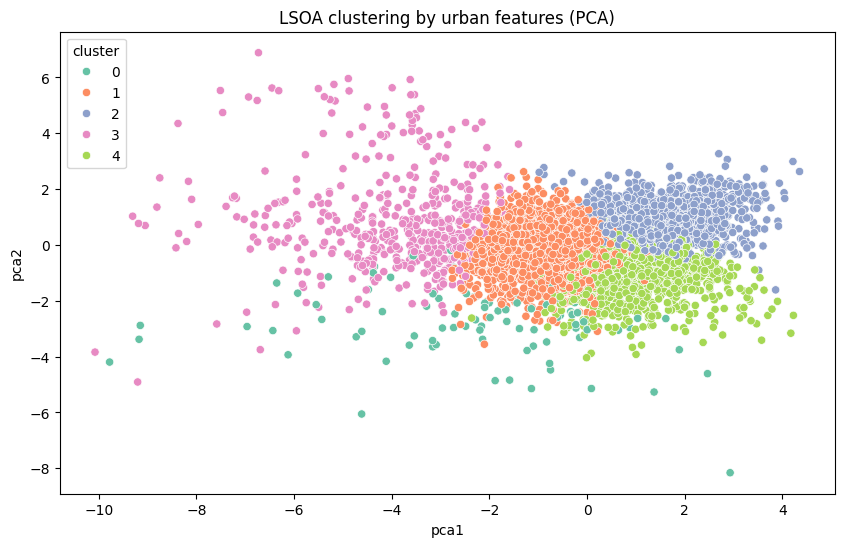

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: 筛选数值型特征列（排除 LSOA 编码等）
feature_cols = [col for col in final_df.columns if col not in ['LSOA 2021']]
X = final_df[feature_cols]

# Step 2: 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: 聚类
kmeans = KMeans(n_clusters=5, random_state=42)  # 👈 你可以改成你想测试的 cluster 数量
final_df['cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: PCA 降维可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
final_df['pca1'] = X_pca[:, 0]
final_df['pca2'] = X_pca[:, 1]

# Step 5: 可视化
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title("LSOA clustering by urban features (PCA)")
plt.show()


In [123]:
cluster_summary = final_df.groupby('cluster')[feature_cols].mean().round(3)
import pandas as pd
pd.set_option('display.max_columns', None)
display(cluster_summary)

,residential_topn_mean,commercial_topn_mean,green_topn_mean,cultural_topn_mean,infrustructure_topn_mean,avg_den,pop_growth,senior_per,minority_p
cluster,,,,,,,,,
0,0.465,0.500,0.441,0.509,0.526,14959.543,0.338,3.591,52.469
1,0.735,0.450,0.481,0.496,0.582,11335.309,-0.010,10.058,55.511
2,0.847,0.478,0.583,0.541,0.617,5135.934,-0.003,18.526,30.077
3,0.404,0.356,0.374,0.394,0.423,16641.600,0.001,8.832,53.001
4,0.724,0.557,0.589,0.547,0.661,12187.518,0.002,10.155,39.337


In [124]:
print(lsoa_label.columns)

Index(['LSOA 2021', 'borough', 'pop_growth', 'avg_den', 'senior_per',
       'minority_p', 'geometry'],
      dtype='object')


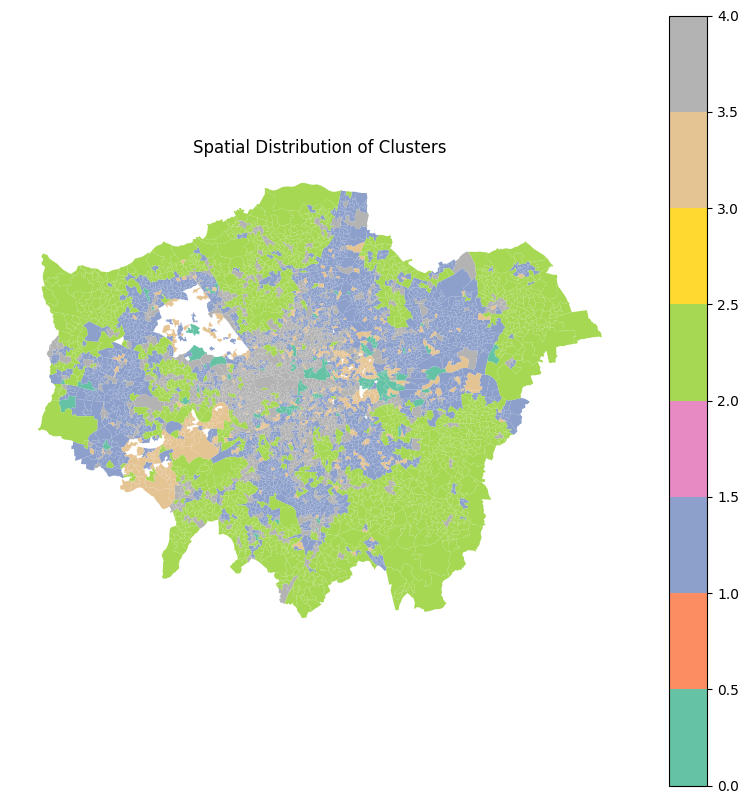

In [125]:
gdf_merged = lsoa_label.merge(final_df_cleaned, on='LSOA 2021')

gdf_merged.plot(column='cluster', cmap='Set2', legend=True, figsize=(10, 10))
plt.title("Spatial Distribution of Clusters")
plt.axis('off')
plt.show()

In [126]:
print(gdf_merged.columns)

Index(['LSOA 2021', 'borough', 'pop_growth_x', 'avg_den_x', 'senior_per_x',
       'minority_p_x', 'geometry', 'residential_topn_mean',
       'commercial_topn_mean', 'green_topn_mean', 'cultural_topn_mean',
       'infrustructure_topn_mean', 'avg_den_y', 'pop_growth_y', 'senior_per_y',
       'minority_p_y', 'cluster', 'pca1', 'pca2'],
      dtype='object')


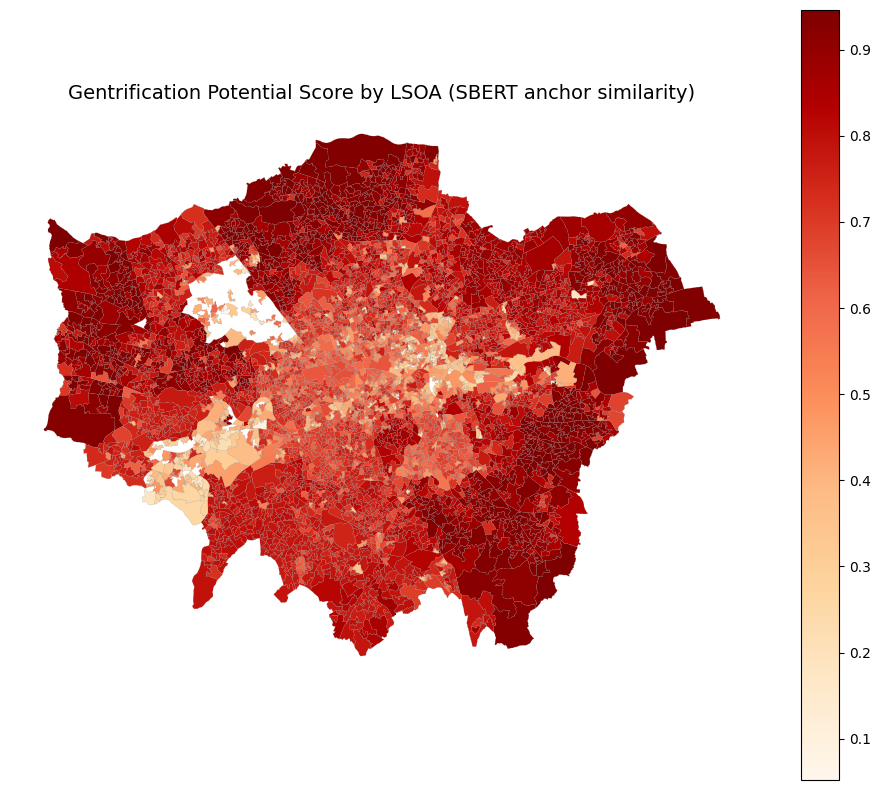

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_merged.plot(column='residential_topn_mean',
             cmap='OrRd',
             linewidth=0.1,
             edgecolor='grey',
             legend=True,
             ax=ax)

ax.set_title("Gentrification Potential Score by LSOA (SBERT anchor similarity)", fontsize=14)
ax.axis('off')
plt.show()
